In [92]:
%matplotlib inline
import gym
import math
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from IPython.display import display
from JSAnimation.IPython_display import display_animation
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from matplotlib import animation

In [2]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(display_animation(anim, default_mode='loop'))

In [258]:
class LearningParameters:
    def __init__(self, state_size, action_size, frames_count):
        self.state_size = state_size
        self.action_size = action_size
        self.frames_count = frames_count
        self.max_memory_size = 1000000
        self.frames_between_think = 100
        
        self.gamma = 0.9                 # discount rate
        self.epsilon = 1.0               # exploration rate
        self.epsilon_start = self.epsilon
        self.epsilon_min = 0.0001        # min exploration rate
        self.learning_rate = 0.1         # learning rate for algorithm
        self.learning_rate_model = 0.01  # learning rate for model (Adam optimizer)
        
    def decay_exploration_rate(self, frame):
        # Linear exploration rate decay (lerp)
#         self.epsilon = self.epsilon_start - \
#                       (self.epsilon_start - self.epsilon_min) * (float(frame) / self.frames_count)
            
        # Exponential rate decay
        # y(0) = start
        # y(1) = start * x
        # y(2) = start * x^2
        # y(steps) = start * x^steps = min => x = (min/start) ^ (1/steps)
        # y(t) = x^t
        self.epsilon = math.pow( math.pow(self.epsilon_min / self.epsilon_start, 1.0 / self.frames_count), frame )

In [279]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(8, input_dim=self.params.state_size, activation='relu'))
#         model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(self.params.action_size, activation='softmax'))
        model.compile(loss='mse', optimizer=Adam(lr=self.params.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def think(self, batch_size):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = self.model.predict(state)[0]
            target[action] = 1.0 if reward > 0 else 0.0
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [247]:
class DQNAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(8, input_dim=self.params.state_size, activation='relu'))
#         model.add(Dense(20, activation='relu', kernel_initializer='uniform'))
        model.add(Dense(self.params.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.params.learning_rate_model))
        return model

    def remember(self, state, action, reward, next_state):
        self.memory.append((state, action, reward, next_state))

    def act(self, state):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state)
    
    def act_greedy(self, state):
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])

    def think(self, batch_size):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = self.model.predict(state)[0]
            target[action] = reward + self.params.gamma * \
                            np.amax(self.model.predict(next_state)[0])
            X[i], Y[i] = state, target
        self.model.fit(X, Y, batch_size=batch_size, epochs=1, verbose=0)

In [251]:
def train(env, agent, params):   
    rewards = []
    state = np.reshape(env.reset(), [1, params.state_size])
    time = 0
    for f in range(1, params.frames_count + 1):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        next_state = np.reshape(next_state, [1, params.state_size])
        
        if time < env.spec.max_episode_steps:
            if done:
                reward = -10
            agent.remember(state, action, reward, next_state)

        state = next_state
        if done or f == params.frames_count - 1:
            rewards.append(time)
            time = 0
            state = np.reshape(env.reset(), [1, params.state_size])
        else:
            time += 1
            
        if f % (params.frames_count / 20) == 0:
            print("frame: {}/{}, reward {}, exploration rate: {:.2}"
              .format(f, params.frames_count, np.mean(rewards[-10:]), params.epsilon))
            
        if (f + 1) % params.frames_between_think == 0:
            agent.think(32)
        
        params.decay_exploration_rate(f - 1)

    return agent, rewards

In [140]:
def evaluate(env, agent, params, render, frames):
    state = env.reset()
    render_frames = []
    for e in range(frames):
        if render:
            render_frames.append(env.render(mode = 'rgb_array'))
        state = np.reshape(state, [1, params.state_size])
        action = agent.act_greedy(state)
        state, reward, done, _ = env.step(action)
        if done or e == frames - 1:
            print("score: {}"
                  .format(e))
            break

    if render:
        env.render(close=True)
        display_frames_as_gif(render_frames)

In [ ]:
# env.render(close=True)
print(env.spec.max_episode_steps)

In [248]:
env = gym.make('CartPole-v0')

[2017-06-11 14:21:13,360] Making new env: CartPole-v0


frame: 150/3000, reward 33.75, exploration rate: 0.63
frame: 300/3000, reward 41.5, exploration rate: 0.4
frame: 450/3000, reward 49.0, exploration rate: 0.25
frame: 600/3000, reward 67.75, exploration rate: 0.16
frame: 750/3000, reward 77.7777777778, exploration rate: 0.1
frame: 900/3000, reward 86.5, exploration rate: 0.063
frame: 1050/3000, reward 99.9, exploration rate: 0.04
frame: 1200/3000, reward 104.4, exploration rate: 0.025
frame: 1350/3000, reward 118.6, exploration rate: 0.016
frame: 1500/3000, reward 118.6, exploration rate: 0.01
frame: 1650/3000, reward 132.6, exploration rate: 0.0063
frame: 1800/3000, reward 117.8, exploration rate: 0.004
frame: 1950/3000, reward 121.9, exploration rate: 0.0025
frame: 2100/3000, reward 118.1, exploration rate: 0.0016
frame: 2250/3000, reward 118.1, exploration rate: 0.001
frame: 2400/3000, reward 126.2, exploration rate: 0.00063
frame: 2550/3000, reward 128.2, exploration rate: 0.0004
frame: 2700/3000, reward 129.9, exploration rate: 0.0

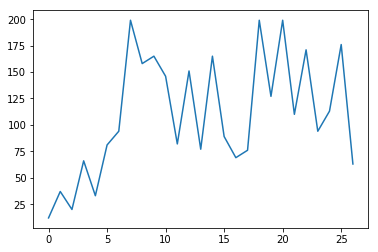

In [280]:
params = LearningParameters(env.observation_space.shape[0], env.action_space.n, 3000)
trained_agent, rewards = train(env, PolicyGradientAgent(params), params)
# trained_agent, rewards = train(env, DQNAgent(params), params)
plt.plot(rewards)

In [289]:
evaluate(env, trained_agent, params, False, 500)

score: 199
